# DEMAND FORECASTING MODEL TRAINING & EVALUATION

In [1]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# --- 1. IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")

Libraries imported


## LOADING THE CLEAN DATA

In [3]:
df = pd.read_csv('final_airbnb_data.csv')
print("Clean data loaded successfully")
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Clean data loaded successfully
Dataset has 1011780 rows and 58 columns.


## PREPARING DATA FOR MODELING

In [4]:
print("\nPreparing data for time-series modeling...")

# Defining the features (X) and the target variable (y)
# We exclude non-feature columns like IDs and the date itself.
features_to_exclude = ['is_booked', 'listing_id', 'date']
X = df.drop(columns=features_to_exclude)
y = df['is_booked']

# Time-Series Split: Spliting the data into a training set and a testing set based on date.
# This ensures training on the past to predict the future.
split_date = '2025-12-01'
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

X_train = train_df.drop(columns=features_to_exclude)
y_train = train_df['is_booked']
X_test = test_df.drop(columns=features_to_exclude)
y_test = test_df['is_booked']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Preparing data for time-series modeling...
Training data shape: (712404, 55)
Testing data shape: (299376, 55)


### HELPER FUNCTION TO PLOT CONFUSION MATRIX 

In [5]:
def plot_confusion_matrix(cm, model_name):
    """
    Generates and displays a heatmap for a given confusion matrix.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Booked', 'Booked'], 
                yticklabels=['Not Booked', 'Booked'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### MODULAR TRAINING AND EVALUATION FUNCTION 

In [6]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Trains a given model, evaluates its performance, and returns metrics and the confusion matrix.
    """
    print(f"\n--- Training {model.__class__.__name__} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return metrics, cm

# DEFINE AND RUN MODELS


--- Training LogisticRegression ---


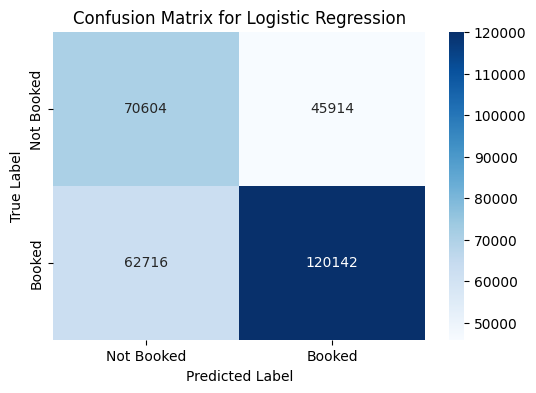


--- Training RandomForestClassifier ---


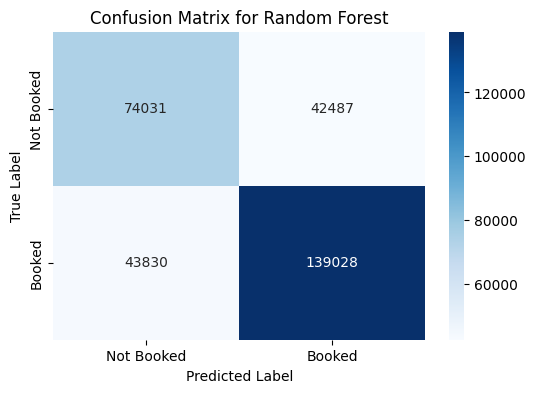


--- Training XGBClassifier ---


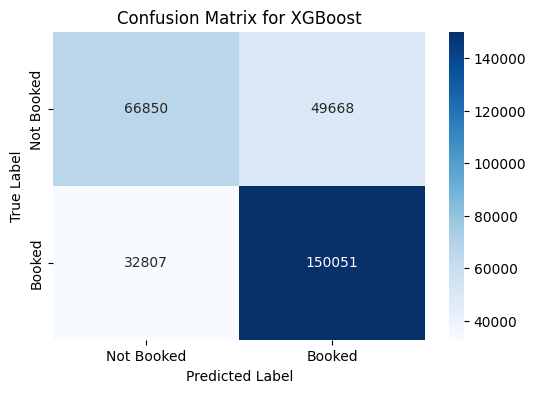


--- Training CatBoostClassifier ---


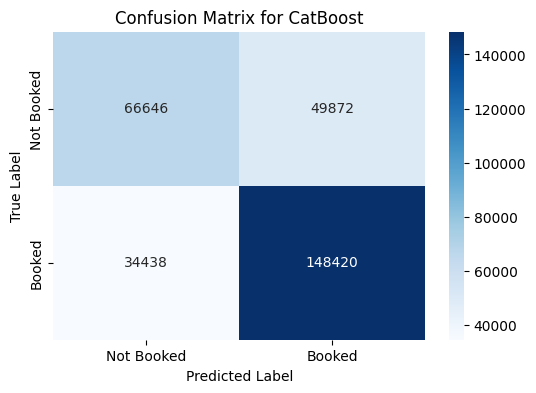



--- Final Model Comparison ---
                     AUC-ROC  Precision  Recall  F1-Score
Model                                                    
Logistic Regression   0.6769     0.7235  0.6570    0.6887
Random Forest         0.7765     0.7659  0.7603    0.7631
XGBoost               0.7884     0.7513  0.8206    0.7844
CatBoost              0.7838     0.7485  0.8117    0.7788

-------------------------------------------------
The champion model is: XGBoost with an AUC-ROC score of 0.7884
-------------------------------------------------

--- Complete ---


In [7]:
# Define all models to be tested in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss',
        use_label_encoder=False, n_estimators=100,
        learning_rate=0.1, max_depth=5, random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100, learning_rate=0.1, depth=5,
        verbose=0, random_seed=42
    )
}

# Loop through the models, train/evaluate, store results, and plot confusion matrices
results_list = []
for model_name, model_instance in models.items():
    model_metrics, conf_matrix = train_evaluate_model(model_instance, X_train, y_train, X_test, y_test)
    model_metrics['Model'] = model_name
    results_list.append(model_metrics)
    # Ploting the confusion matrix for the current model
    plot_confusion_matrix(conf_matrix, model_name)

# --- DISPLAY RESULTS IN A TABLE ---
# Converting the list of results into a clean pandas DataFrame
results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model') # Setting the model name as the index

print("\n\n--- Final Model Comparison ---")
print(results_df.round(4))

# Identify the champion model based on AUC-ROC
champion_model_name = results_df['AUC-ROC'].idxmax()
champion_model_score = results_df['AUC-ROC'].max()

print("\n-------------------------------------------------")
print(f"The champion model is: {champion_model_name} with an AUC-ROC score of {champion_model_score:.4f}")
print("-------------------------------------------------")

print("\n--- Complete ---")
